In [ ]:
#installing packages
!pip -q install pandas numpy scikit-learn matplotlib seaborn umap-learn gradio

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import average_precision_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
np.random.seed(42)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Datasets/creditcard.csv')
# Downsample for faster training
df = df.sample(n=20000, random_state=42)

Mounted at /content/drive


Dataset shape: (20000, 31)
            Time         V1        V2         V3        V4         V5  \
43428    41505.0 -16.526507  8.584972 -18.649853  9.505594 -13.793819   
49906    44261.0   0.339812 -2.743745  -0.134070 -1.385729  -1.451413   
29474    35484.0   1.399590 -0.590701   0.168619 -1.029950  -0.539806   
276481  167123.0  -0.432071  1.647895  -1.669361 -0.349504   0.785785   
278846  168473.0   2.014160 -0.137394  -1.015839  0.327269  -0.182179   

              V6         V7        V8        V9  ...       V21       V22  \
43428  -2.832404 -16.701694  7.517344 -8.507059  ...  1.190739 -1.127670   
49906   1.015887  -0.524379  0.224060  0.899746  ... -0.213436 -0.942525   
29474   0.040444  -0.712567  0.002299 -0.971747  ...  0.102398  0.168269   
276481 -0.630647   0.276990  0.586025 -0.484715  ...  0.358932  0.873663   
278846 -0.956571   0.043241 -0.160746  0.363241  ... -0.238644 -0.616400   

             V23       V24       V25       V26       V27       V28  Amount  \

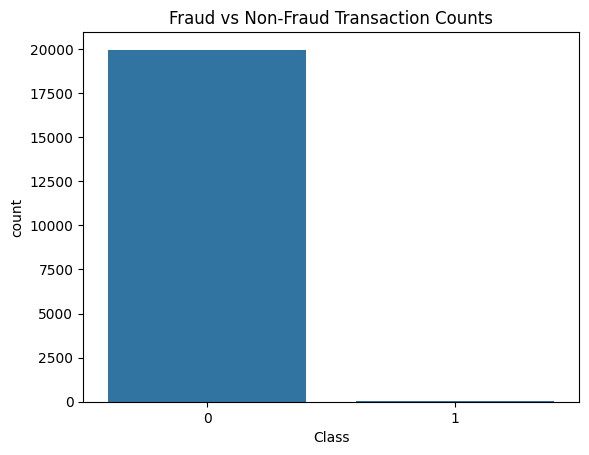

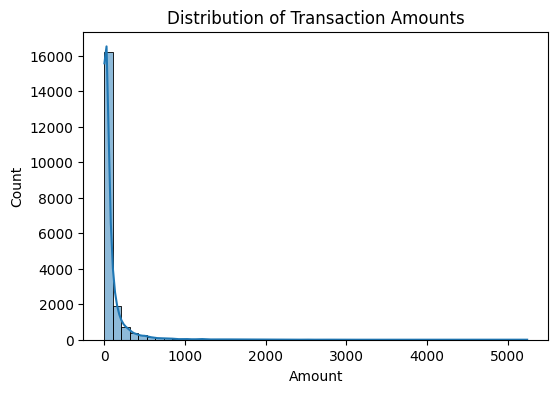

In [ ]:
#EDA = Exploring the dataset before modeling.

# Shape of dataset
print("Dataset shape:", df.shape)
# First 5 rows
print(df.head())
# Info about columns
print(df.info())
# Check missing values
print(df.isnull().sum())
# Class distribution (Fraud vs Non-Fraud)
print(df['Class'].value_counts())
# Percentage of fraud cases
fraud_percentage = (df['Class'].value_counts()[1] / len(df)) * 100
print(f"Fraud cases percentage: {fraud_percentage:.4f}%")

# Class distribution plot
sns.countplot(x='Class', data=df)
plt.title("Fraud vs Non-Fraud Transaction Counts")
plt.show()

# Transaction Amount distribution
plt.figure(figsize=(6,4))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.show()



In [ ]:
# sort by time- To prevent data leakage, I performed a time-aware split of the dataset,
# ensuring the model was trained only on past transactions and tested on future ones.
df = df.sort_values('Time').reset_index(drop=True)
split_idx = int(0.70 * len(df))
train_df = df.iloc[:split_idx].copy()
val_df   = df.iloc[split_idx:].copy()

'''#This is for very large dataset- The dataset is highly imbalanced (fraud ≈ 0.17%).
To avoid very long training and useless imbalance,you:Keep all fraud cases.Randomly sample
only some normal transactions (20,000 for train, 10,000 for val).
FAST mode sizes (tweak as you like)

FAST_MODE = True
N_NORMAL_TRAIN = 20000
N_NORMAL_VAL   = 10000
def make_fast(df_part):
    fraud = df_part[df_part['Class'] == 1]
    non_fraud = df_part[df_part['Class'] == 0]
    target_n = N_NORMAL_TRAIN if df_part is train_df else N_NORMAL_VAL
    if FAST_MODE:
        non_fraud = non_fraud.sample(n=min(target_n, len(non_fraud)), random_state=42)
    # keep all fraud + sampled normals
    return pd.concat([fraud, non_fraud]).sample(frac=1, random_state=42).reset_index(drop=True)

train_fast = make_fast(train_df)
val_fast   = make_fast(val_df)

print(train_fast['Class'].value_counts(), "\n---\n", val_fast['Class'].value_counts())'''

'#This is for very large dataset- The dataset is highly imbalanced (fraud ≈ 0.17%).\nTo avoid very long training and useless imbalance,you:Keep all fraud cases.Randomly sample\nonly some normal transactions (20,000 for train, 10,000 for val).\nFAST mode sizes (tweak as you like)\n\nFAST_MODE = True\nN_NORMAL_TRAIN = 20000\nN_NORMAL_VAL   = 10000\ndef make_fast(df_part):\n    fraud = df_part[df_part[\'Class\'] == 1]\n    non_fraud = df_part[df_part[\'Class\'] == 0]\n    target_n = N_NORMAL_TRAIN if df_part is train_df else N_NORMAL_VAL\n    if FAST_MODE:\n        non_fraud = non_fraud.sample(n=min(target_n, len(non_fraud)), random_state=42)\n    # keep all fraud + sampled normals\n    return pd.concat([fraud, non_fraud]).sample(frac=1, random_state=42).reset_index(drop=True)\n\ntrain_fast = make_fast(train_df)\nval_fast   = make_fast(val_df)\n\nprint(train_fast[\'Class\'].value_counts(), "\n---\n", val_fast[\'Class\'].value_counts())'

In [ ]:
def build_features(df_):
    X = df_.filter(regex=r'^V\d+$').copy()   # V1..V28
    # robust scale amount
    amt = df_[['Amount']].copy()
    hours = ((df_['Time']/3600) % 24).astype(int)
    X['hour'] = hours
    X['is_night'] = ((hours >= 0) & (hours <= 5)).astype(int)
    return X, amt

Xtr, atr = build_features(train_df)
Xva, ava = build_features(val_df)

amt_scaler = RobustScaler().fit(atr)          # train-only
Xtr['Amount_scaled'] = amt_scaler.transform(atr)
Xva['Amount_scaled'] = amt_scaler.transform(ava)

y_val = val_df['Class'].values              # labels ONLY for evaluation
Xtr.shape, Xva.shape


((14000, 31), (6000, 31))

In [ ]:
#base line models
#Simple rule baseline
def rule_scores(df_):
    hours = ((df_['Time']/3600) % 24).astype(int)
    is_night = ((hours >= 0) & (hours <= 5)).astype(int)
    amt = df_['Amount'].values
    # high score if very large amount and at night
    return (is_night * 1.0) + (amt / (np.percentile(amt, 99) + 1e-9))

rule_s_val = rule_scores(val_df)

#Isolation Forest (IF)          MAIN ALGORITHM
iso = IsolationForest(n_estimators=300, max_samples='auto', n_jobs=-1, random_state=42)
iso.fit(Xtr)
iso_s_val = -iso.score_samples(Xva)  # invert

#Local Outlier factor in novelty mode
lof = LocalOutlierFactor(n_neighbors=35, novelty=True, n_jobs=-1)
lof.fit(Xtr)
lof_s_val = -lof.score_samples(Xva)  # invert


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [ ]:
#Evaluation that matches analyst workflows  We’ll use Precision@K, Recall@K, PR-AUC (Average Precision).
from sklearn.metrics import precision_recall_curve

def precision_at_k(y_true, scores, k=200):
    idx = np.argsort(scores)[::-1][:k]
    return float(y_true[idx].mean())

def recall_at_k(y_true, scores, k=200):
    idx = np.argsort(scores)[::-1][:k]
    return float(y_true[idx].sum() / (y_true.sum() + 1e-9))

def pr_auc(y_true, scores):
    return float(average_precision_score(y_true, scores))

def summarize(name, scores):
    print(f"{name:16s}  Prec@100={precision_at_k(y_val, scores, 100):.3f}  "
          f"Prec@200={precision_at_k(y_val, scores, 200):.3f}  "
          f"Recall@200={recall_at_k(y_val, scores, 200):.3f}  "
          f"PR-AUC={pr_auc(y_val, scores):.3f}")

summarize("Rule", rule_s_val)
summarize("IsolationForest", iso_s_val)
summarize("LOF", lof_s_val)


Rule              Prec@100=0.010  Prec@200=0.010  Recall@200=0.200  PR-AUC=0.005
IsolationForest   Prec@100=0.040  Prec@200=0.030  Recall@200=0.600  PR-AUC=0.033
LOF               Prec@100=0.060  Prec@200=0.035  Recall@200=0.700  PR-AUC=0.311


In [ ]:
def rank_ensemble(*scores_list):
    ranks = np.vstack([np.argsort(np.argsort(-s)) for s in scores_list])  # lower rank = more anomalous
    return -ranks.mean(axis=0)

ens_s_val = rank_ensemble(iso_s_val, lof_s_val)
summarize("Ensemble", ens_s_val)


Ensemble          Prec@100=0.070  Prec@200=0.035  Recall@200=0.700  PR-AUC=0.086


VISUALS:

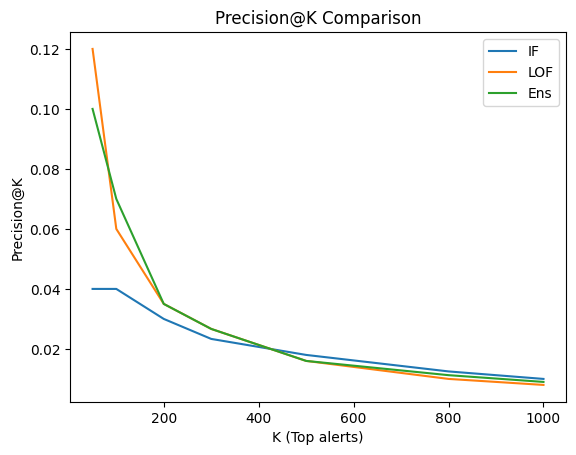

In [ ]:
#Precision@K curve
def prec_curve(y_true, scores, ks=(50,100,200,300,500,800,1000)):
    return ks, [precision_at_k(y_true, scores, k) for k in ks]

plt.figure()
for name, s in {"IF": iso_s_val, "LOF": lof_s_val, "Ens": ens_s_val}.items():
    ks, precs = prec_curve(y_val, s)
    plt.plot(ks, precs, label=name)
plt.xlabel("K (Top alerts)"); plt.ylabel("Precision@K"); plt.title("Precision@K Comparison"); plt.legend(); plt.show()


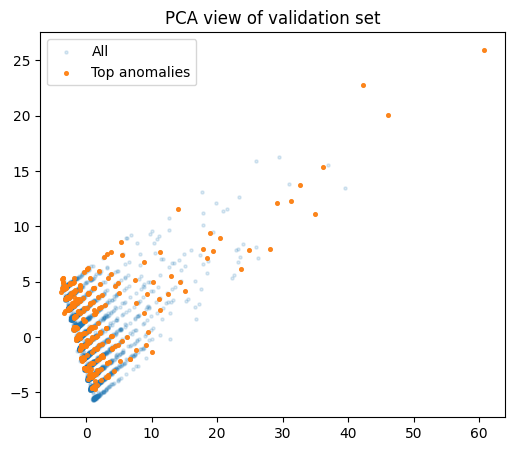

In [ ]:
#2D scatter (PCA) highlighting top anomalies
pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(Xva)
top_idx = np.argsort(ens_s_val if 'ens_s_val' in globals() else iso_s_val)[::-1][:300]
plt.figure(figsize=(6,5))
plt.scatter(XY[:,0], XY[:,1], s=5, alpha=0.15, label="All")
plt.scatter(XY[top_idx,0], XY[top_idx,1], s=7, alpha=0.9, label="Top anomalies")
plt.title("PCA view of validation set"); plt.legend(); plt.show()

In [ ]:
#top k suspicious tranaction
def topk_table(df_part, scores, k=200):
    idx = np.argsort(scores)[::-1][:k]
    out = df_part.iloc[idx][['Time','Amount','Class']].copy()
    out.insert(0, "rank", np.arange(1, len(idx)+1))
    out['anomaly_score'] = np.round(scores[idx], 6)
    return out

top200 = topk_table(val_df, ens_s_val if 'ens_s_val' in globals() else iso_s_val, 200)
top200.head()

,rank,Time,Amount,Class,anomaly_score
16141,1,145773.0,1210.00,0,-2.5
14240,2,134033.0,1402.38,0,-3.0
14248,3,134070.0,660.38,0,-4.0
16659,4,148806.0,152.00,0,-4.0
15484,5,141655.0,3502.11,0,-5.0


Deployed

In [ ]:
import gradio as gr

SCORES = {
    "IsolationForest": iso_s_val,
    **({"Ensemble": ens_s_val} if 'ens_s_val' in globals() else {})
}

def show_topk(model_name, k):
    s = SCORES[model_name]
    return topk_table(val_df, s, int(k))

demo = gr.Interface(
    fn=show_topk,
    inputs=[gr.Dropdown(list(SCORES.keys()), value=list(SCORES.keys())[0], label="Model"),
            gr.Slider(50, 1000, step=50, value=200, label="Top-K Alerts")],
    outputs=gr.Dataframe(),
    title="Unsupervised Fraud Alerts (Validation Set)",
    description="Ranked suspicious transactions (no labels used in training)."
)
demo.launch(share=False)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>